# Scratch Pad: A symbolic playground for Seq2Seq models

```
what does Henry do? <scratch_pad> search('Henry') -> ['Henry is a School Psychologist'] </scratch_pad> School Psychologist

what is 556 - 301? <scratch_pad> 556 - 301 -> 255 </scratch_pad> 255
```

In [148]:
from rank_bm25 import BM25Okapi
from src.models_and_transforms.BERT_models import CausalBERT
from src.models_and_transforms.GPT2_models import GPT2_Actor_Critic_Model
from src.models_and_transforms.text_transforms import Numericalise_Transform, Scratch_Pad_Sequence_Policy_Creator_Transform, \
                                                        Rename_Transform, Class_Rebalance_Transform
from src.pipe_datasets import Scratch_Pad_Policy_Dataset
import re
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, GPT2TokenizerFast, GPT2Model
from transformers import BertConfig, BertTokenizerFast, BertForMaskedLM
from tokenizers import processors, Tokenizer
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, Callback, seed_everything
import numpy as np
import json
from itertools import compress as mask
import sys
import tqdm
from time import perf_counter 
import random
import copy
import matplotlib.pyplot as plt

from src.ScratchPad import ScratchPadGame, EpisodeUtility
from src.FastMCTS import FastMCTS
from dotmap import DotMap
import numpy as np
from time import perf_counter

from src.environments import Scratch_Pad_Environment
from src.FasterMCTS import FasterMCTS
from src.RL_trainer import AlphaZero_Trainer

from src.useful_utils import chunks
from src.models_and_transforms.GPT2_models import GPT2_Scratch_Pad_Model
sys.path.insert(0,"src/external_repos/pyfuzz/")

%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Searching function

In [2]:
corpus = [
    "Hello there good man!",
    "It is quite windy in London",
    "How is the weather today?"
]
tokenized_corpus = [re.findall(r"[\w']+|[.,!?;]", doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [3]:
def search(q, n=1):
    return bm25.get_top_n(q.split(), corpus, n=n)

## Using BERT for AlphaZero style learning
The model will be both responsible for state $s$ evaluation into a value $v$ and polilcy $\textbf{p}$

\begin{equation*}
(v,\textbf{p})=f(s|\theta)
\end{equation*}

In [2]:
config = BertConfig()
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')

In [3]:
config.num_attention_heads = 1
config.hidden_size = 10
config.num_hidden_layers = 3
config.intermediate_size = 16
config.n_ctx = 512
config.n_positions = 512
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'

In [9]:
model = AlphaBERT(config, mask_token_id=tokenizer.token_to_id('[MASK]'), 
                  value_token_id=tokenizer.token_to_id('[VALUE]'), 
                  pad_token_id=tokenizer.token_to_id('[PAD]'))

In [13]:
tokens = torch.tensor([i.ids for i in tokenizer.encode_batch(['foo'])], dtype=torch.long)
print("Input tokens: "+ str(tokens))
model(tokens)[0].shape

Input tokens: tensor([[77, 86, 86]])


torch.Size([1, 270])

In [6]:
batch = {'input_ids':tokens, 
         'target_policy':torch.tensor([[33409]]), 
#          'target_value':torch.tensor([[1.0]]),
         'attention_mask':torch.ones_like(tokens)}

In [9]:
model.training_step(batch,0)

{'loss': tensor(10.0868, grad_fn=<AddBackward0>),
 'log': {'train_loss': tensor(10.0868, grad_fn=<AddBackward0>)}}

## Monte Carlos Tree Search and simulation

In [173]:
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')
SPGame = ScratchPadGame(tokenizer)
config = BertConfig()
config.num_attention_heads = 1
config.hidden_size = 10
config.num_hidden_layers = 3
config.intermediate_size = 32
config.n_ctx = 512
config.n_positions = 512
config.temp = 1
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'
model = AlphaBERT(config, mask_token_id=tokenizer.token_to_id('[MASK]'), 
                  value_token_id=tokenizer.token_to_id('[VALUE]'), 
                  pad_token_id=tokenizer.token_to_id('[PAD]'))

args = {'num_episodes':3,
        'num_sims_per_turn':10,
        'policy_exploration_weight':0.5}

In [15]:
explorer = EpisodeUtility(SPGame, **args)

In [11]:
explored_examples = explorer.explore(model)

Exploring env: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Performed 3 episodes in 3.31s. 0 positive
------------------
What is 3+4?7[EOS]
What is 3+4? Moines polymorphTHER Butter Moinesxffxff Moinesowskixff136OH
Top 3 next actions: ['ennial', ' irony', ' borrowed']
Current reward: -1

What is 2+3?5[EOS]
What is 2+3? borrowed Moines Moines Moinesowski136136 partic thwarted places polymorph MoinesWould irony
Top 3 next actions: [' Moines', ' Acceler', ' polymorph']
Current reward: -1



In [15]:
ideal_answer = "What is 3+4?<ScratchPad>3+4>>>7\n</ScratchPad>7[EOS]"
target = "What is 3+4?7[EOS]"
ideal_canon_state = SPGame.toCanonical(ideal_answer, target)
print(ideal_canon_state)
custom_examples = explorer.decomposePositiveEpisode(ideal_canon_state)
print(custom_examples[4])

{'current_state': tensor([ 2061,   318,   513,    10,    19,    30, 50260,    18,    10,    19,
        33409,    22, 50259, 50261,    22, 50257]), 'target_state': tensor([ 2061,   318,   513,    10,    19,    30,    22, 50257])}
{'canonical_state': {'current_state': tensor([2061,  318,  513,   10]), 'target_state': tensor([ 2061,   318,   513,    10,    19,    30,    22, 50257])}, 'pi': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'id': 'custom', 'reward': 1}


In [16]:
train_samples = copy.deepcopy(custom_examples)
train_samples = explorer.prepExamplesForModel_Transform(train_samples)
train_samples[0]

{'canonical_state': {'current_state': tensor([], dtype=torch.int64),
  'target_state': tensor([ 2061,   318,   513,    10,    19,    30,    22, 50257])},
 'pi': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'id': 'custom',
 'reward': 1,
 'input_ids': tensor([[50263, 50262]])}

In [17]:
train_samples = Class_Rebalance_Transform(field='reward')(train_samples)

In [18]:
train_samples = Rename_Transform(fields=[('pi','target_policy'),('reward','target_value')])(train_samples)

In [19]:
train_dataset = Scratch_Pad_Policy_Dataset(train_samples, slow_pipe=[], real_time_pipe=[])

In [20]:
train_dataloader = train_dataset.to_dataloader(2, shuffle=True)
batch = next(iter(train_dataloader))
batch

{'input_ids': tensor([[ 2061,   318,   513,    10,    19,    30, 50260,    18,    10,    19,
          33409,    22, 50259, 50261,    22, 50263, 50262],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,  2061, 50263, 50262]]),
 'attention_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]]),
 'target_policy': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'target_value': tensor([1., 1.])}

In [21]:
batch['target_policy'][0].argmax()

tensor(50257)

In [22]:
trainer = Trainer(gpus=1, gradient_clip_val=1.0, amp_level='O1')
trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name        | Type      | Params
------------------------------------------
0 | BERT        | BertModel | 542 K 
1 | dropout     | Dropout   | 0     
2 | value_layer | Linear    | 11    
3 | LM_layer    | Linear    | 552 K 
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


1

In [88]:
policy_logit = torch.tensor([[0.03, 0.4, -2, 0.9],
                             [0.1,  0.2, 0.6, -3]])
target = torch.tensor([1, 3])
one_hot_target = torch.tensor([[0,1.0,0,0],
                               [0,0,0,1.0]])

In [89]:
nn.CrossEntropyLoss()(policy_logit.view(-1,4), target.view(-1))

tensor(2.8337)

In [90]:
-torch.dot(one_hot_target.view(-1)**1, torch.log(policy_logit.softmax(-1)).view(-1))/policy_logit.shape[0]

tensor(2.8337)

In [23]:
batch_idx = 0
print(batch['target_policy'][batch_idx].argmax())
model.eval()
model.predict(torch.tensor([[2061,   318]]))[0][batch_idx].argsort(descending=True)[:10]

tensor(50257)


tensor([  513,  2061,    19,   318,    10,    18, 50261, 50257,    22, 50260])

## Creating prompts and answers

In [388]:
def customPromptsAndAnswers(prompt_type, n=100):
    '''
    Generate n prompt-answer pairs of type prompt_type.
    prompt_type: str: 'simple_addition'
    
    returns: [(str: prompt string, str: prompt and answer string)]
    '''
    if prompt_type == 'simple_addition':
        pairs = []
        for i in range(n):
            a = random.randrange(0,30)
            b = random.randrange(0,30)
            prompt = f'What is {a}+{b}?'
            target = f'What is {a}+{b}?{a+b}[EOS]'
            pairs.append((prompt, target))
        return pairs
    if prompt_type == 'simple_addition_with_answer_level_0':
        pairs = []
        for i in range(n):
            a = random.randrange(0,30)
            b = random.randrange(0,30)
            prompt = f'What is {a}+{b}?[SP]{a}+{b}>>>{a+b}\n[ESP]'
            target = f'What is {a}+{b}?{a+b}[EOS]'
            pairs.append((prompt, target))
        return pairs
    else:
        raise f'{prompt_type} not recognised'

In [389]:
customPromptsAndAnswers('simple_addition_with_answer_level_0', 4)

[('What is 25+18?[SP]25+18>>>43\n[ESP]', 'What is 25+18?43[EOS]'),
 ('What is 15+10?[SP]15+10>>>25\n[ESP]', 'What is 15+10?25[EOS]'),
 ('What is 25+14?[SP]25+14>>>39\n[ESP]', 'What is 25+14?39[EOS]'),
 ('What is 4+15?[SP]4+15>>>19\n[ESP]', 'What is 4+15?19[EOS]')]

In [390]:
custom_positive_pairs = [('What is 3+4?[SP]3+4>>>7\n[ESP]7[EOS]', 'What is 3+4?7[EOS]'),
                         ('What is 17+5?[SP]17+5>>>22\n[ESP]22[EOS]', 'What is 17+5?22[EOS]'),
                         ('What is 22+1?[SP]22+1>>>23\n[ESP]23[EOS]', 'What is 22+1?23[EOS]')]

In [385]:
prompt_and_answers = customPromptsAndAnswers('simple_addition_with_answer_level_0', 200)
SPGame = ScratchPadGame(tokenizer, prompt_target_pairs=prompt_and_answers, device='cpu')

args = {'num_episodes':1000,
        'num_sims_per_turn':2,
        'policy_exploration_weight':0.5}
episode_utility = EpisodeUtility(SPGame, **args)

custom_positive_examples = []
for prompt, ideal_target in custom_positive_pairs:
    custom_positive_examples += episode_utility.decomposePositiveEpisode((SPGame.toCanonical(prompt, ideal_target)))
custom_positive_examples = Rename_Transform(fields=[('pi','target_policy'),('reward','target_value')])(custom_positive_examples)

NameError: name 'stmnt_out' is not defined

In [380]:
episode_utility.fullLoopTrainer(model, custom_examples=custom_positive_examples, max_epochs=100)

ValueError: max() arg is an empty sequence

In [33]:
exs = episode_utility.explore(model)

Exploring env: 100%|██████████| 1000/1000 [01:17<00:00, 12.83it/s]

Performed 1000 episodes in 77.96s. 0 positive
------------------
What is 3+3?6[EOS]
What is 3+3?<ScratchPad>3+3>>>6
</ScratchPad> Somehow Exclusive
Top 3 next actions: [' Hercules', ' Exclusive', ' UPS']
Current reward: -1

What is 6+2?8[EOS]
What is 6+2?<ScratchPad>6+2>>>8
</ScratchPad>lb
Top 3 next actions: [' comprehensive', 'lb', ' driveway']
Current reward: -1



## Performance profiling

In [124]:
custom_positive_examples[0]['canonical_state']['input_ids']

tensor([[50263, 50262]])

In [271]:
a = torch.tensor([[1,2,3],[4,5,6]])
a[torch.tensor([0,1]), torch.tensor([1,2])] = torch.tensor([8,9])
a

tensor([[1, 8, 3],
        [4, 5, 9]])

In [8]:
current_states = torch.nn.utils.rnn.pad_sequence([sample['canonical_state']["input_ids"].flip(1)[0] for sample in custom_positive_examples[:3]], 
                                                 padding_value=50258, batch_first=True).flip(1)
target_strings = [sample['canonical_state']["string_rep"] for sample in custom_positive_examples[:3]]

KeyError: 'input_ids'

In [8]:
current_states = torch.tensor(tokenizer.encode('What is 3+4?').ids, dtype=torch.long, device='cpu').unsqueeze(0)

In [9]:
current_states.shape

torch.Size([1, 7])

In [10]:
target_strings = ['What is 3+4?7[EOS]']

In [11]:
_ = model.eval()
_ = model.to("cpu")

In [375]:
sorted(list(faster_MCTS.cache.items()), key=lambda s: s[1]['N'], reverse=True)[:10]

[('What is 3+4?',
  {'state': tensor([268, 267, 228,  26,  18,  27,  38]),
   'N': tensor([1161.]),
   'Qa': tensor(indices=tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
                            11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
                            22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
                            33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
                            44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
                            55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
                            66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
                            77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
                            88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                            99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                           110, 111, 112, 113, 114, 115, 116, 117, 118, 11

In [174]:
faster_MCTS = FasterMCTS(SPGame, model)
faster_MCTS.batchSearch(current_states, target_strings, sample=False)

visited


tensor([-0.1727])

In [374]:
faster_MCTS.cache['What is 3+4?']['Na']

tensor(indices=tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
                         11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
                         22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
                         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
                         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
                         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
                         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
                         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
                         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
                        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
                        132, 133, 134, 135, 136, 137

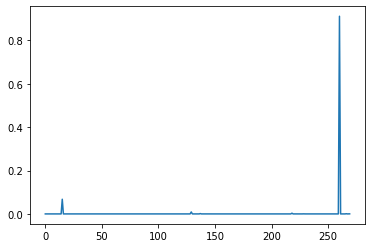

In [381]:
probs = faster_MCTS.getActionProb(current_states, temp=5)
plt.plot(range(270), probs[0])

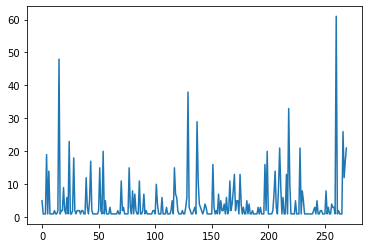

In [355]:
plt.plot(range(270), faster_MCTS.cache['What is 3+4?']['Na'].to_dense())

In [333]:
faster_MCTS.batchSearch(current_states, target_strings, sample=False)

tensor([-0.4327])

In [336]:
for i in range(500):
    faster_MCTS.batchSearch(current_states, target_strings, sample=False)

In [358]:
current_states

tensor([[268, 267, 228,  26,  18,  27,  38]])

In [379]:
tokenizer.decode([228])

' '

In [330]:
faster_MCTS.batchSearch(current_states, target_strings, sample=False)

visited
top nex actions tensor([[108, 201, 117, 163, 106, 156,  54, 206, 138, 150]]) for states tensor([[268, 267, 228,  26,  18,  27,  38]])
selecting action tensor([[108]]) for states tensor([[268, 267, 228,  26,  18,  27,  38]])
visited
top nex actions tensor([[116,  23, 220,  14,  52,  16,  10,  73, 108, 201]]) for states tensor([[268, 267, 228,  26,  18,  27,  38, 108]])
selecting action tensor([[156]]) for states tensor([[268, 267, 228,  26,  18,  27,  38, 108]])
visited
returned_values tensor([-0.4261])
pre Na tensor(indices=tensor([], size=(1, 0)),
       values=tensor([], size=(0,)),
       size=(270,), nnz=0, layout=torch.sparse_coo) for a tensor([156])
post Na tensor(indices=tensor([[156]]),
       values=tensor([1.]),
       size=(270,), nnz=1, layout=torch.sparse_coo) for a tensor([156])
returned_values tensor([-0.4261])
pre Na tensor(indices=tensor([[ 10,  14,  16,  23,  52,  73, 116, 220]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(270,), nnz=

tensor([-0.4261])

In [318]:
%debug

> /nfs/phd_by_carlos/notebooks/src/FasterMCTS.py(118)batchSearch()
    116             self.cache[string_reps[i]]['Qa'] = dense_Qa.to_sparse()
    117 #             print('Qa', self.cache[string_reps[i]]['Qa'], 'for a', a[i])
--> 118 
    119             print('pre Na', self.cache[string_reps[i]]['Na'], 'for a', a[i])
    120             dense_Na[a[i]] += 1



ipdb>  exit


In [302]:
faster_MCTS.cache['What is 3+4?']['Na']

tensor(indices=tensor([[ 10,  14,  16,  23,  52,  73, 108, 116, 220]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(270,), nnz=9, layout=torch.sparse_coo)

In [304]:
dense_Na = faster_MCTS.cache['What is 3+4?']['Na'].to_dense()
dense_Na[73] += 1
faster_MCTS.cache['What is 3+4?']['Na'] = dense_Na.to_sparse()

In [305]:
faster_MCTS.cache['What is 3+4?']['Na']

tensor(indices=tensor([[ 10,  14,  16,  23,  52,  73, 108, 116, 220]]),
       values=tensor([1., 1., 1., 1., 1., 2., 1., 1., 1.]),
       size=(270,), nnz=9, layout=torch.sparse_coo)

In [12]:
%mprun -f faster_MCTS.batchSearch faster_MCTS.batchSearch(current_states, target_strings)

visited
visited
visited



Filename: /nfs/phd_by_carlos/notebooks/src/FasterMCTS.py

Line #    Mem usage    Increment  Occurences   Line Contents
    43   7647.7 MiB   5228.6 MiB           3       def batchSearch(self, current_states, target_strings, sim_action_select_temp=1, sample=True):
    44                                                 '''
    45                                                 current_states: padded Long tensor: [N, seq_len]
    46                                                 target_states: [str]: [N]
    47                                                 '''
    48   7647.7 MiB      0.0 MiB           3           N = current_states.shape[0]
    49   7647.7 MiB      0.0 MiB           3           vocab_size = self.game.getActionSize()
    50   7647.7 MiB      0.0 MiB           3           string_reps = self.game.batchStringRep(current_states) # [str*N]
    51   7647.7 MiB      0.1 MiB           3           game_states = self.game.batchGameEnded(current_states, target_strings) # torch.te

In [37]:
SPGame.batchGameEnded(current_states, target_strings)

RuntimeError: All input tensors must be on the same device. Received cuda:0 and cpu

## Trying out tokenizers

In [298]:
from tokenizers import ByteLevelBPETokenizer, Tokenizer
tokenizer = ByteLevelBPETokenizer(add_prefix_space=False)

# And then train
tokenizer.train(
    ["datasets/ScratchPad/samples.txt"],
    vocab_size=1000,
    min_frequency=2,
    show_progress=True,
    special_tokens=['[PAD]','[BOS]','[EOS]','[VALUE]','[MASK]','[NL]','[SP]', '[ESP]','>>>'],
)
tokenizer.enable_padding(direction='left')

tokenizer.save('datasets/ScratchPad/tokenizer_simple.json')
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')

inputs = tokenizer.encode('[VALUE]What is 8+4?[SP]3+4>>>7[NL][ESP]7[EOS]')
print(inputs.ids)
print(inputs.tokens)
tokenizer.decode(inputs.ids, skip_special_tokens=False)

[3, 269, 268, 270, 19, 28, 39, 6, 27, 19, 28, 8, 31, 5, 7, 31, 2]
['[VALUE]', 'What', 'Ġis', 'Ġ8', '+', '4', '?', '[SP]', '3', '+', '4', '>>>', '7', '[NL]', '[ESP]', '7', '[EOS]']


'[VALUE]What is 8+4?[SP]3+4>>>7[NL][ESP]7[EOS]'

## Clean Environment

In [853]:
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')
env = Scratch_Pad_Environment(tokenizer, device='cpu')

args = {'num_episodes':1000,
        'num_sims_per_turn':2,
        'policy_exploration_weight':0.5}
# trainer = EpisodeUtility(SPGame, **args)


In [114]:
config = BertConfig()
config.num_attention_heads = 8
config.hidden_size = 256
config.num_hidden_layers = 12
config.intermediate_size = 1024
config.n_ctx = 512
config.n_positions = 512
config.is_decoder = True
config.temp = 1
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'
model = CausalBERT(config, bos_id=tokenizer.token_to_id('[BOS]'), 
                            pad_id=tokenizer.token_to_id('[PAD]'))

In [9]:
_ = model.cuda()
# _ = model.eval()

In [165]:
print(env.strings_to_state(['[BOS]Copy "S9Hi":']))
current_states = env.strings_to_state(['[BOS]Copy "0Kb4nj0MxOXcZX":0Kb4nj0M'])
target_strings = np.array(['What is 3+4?7[EOS]'])
current_states

tensor([[  1,  43,  87,  88,  97, 229,  10,  59,  33,  48,  81,  10,  34]])


tensor([[  1,  43,  87,  88,  97, 229,  10,  24,  51,  74,  28,  86,  82,  24,
          53,  96,  55,  64,  75,  66,  64,  10,  34,  24,  51,  74,  28,  86,
          82,  24,  53]])

In [166]:
pi = model.forward(current_states)[0][0][-1]
env.to_hash(pi.argsort(descending=True)[:10].unsqueeze(1))

['x', 'T', 'r', 'o', 'O', 'j', 'c', '4', 'X', '0']

In [215]:
trainer = AlphaZero_Trainer(model, env)

In [103]:
samples = trainer.decomposeSupervisedEpisodes(['foo[EOS]', 'f[EOS]'], prompt_strings=None)

In [104]:
train_dataset = Scratch_Pad_Policy_Dataset(samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(2)

In [105]:
batch = next(iter(train_dataloader))
batch

In [172]:
model.training_step(batch,0)

{'loss': tensor(9.6406, grad_fn=<DivBackward0>),
 'log': {'train_loss': tensor(9.6406, grad_fn=<DivBackward0>)}}

In [206]:
_ = model.eval()
print(env.strings_to_state(['[BOS]Copy "S9Hi":']))
current_states = env.strings_to_state(['[BOS]What is 5+4?[SP]5+4>>>9\n[ESP]9[EOS]'])
print(current_states)
pi = model.forward(current_states)[0][0][-1]
env.to_hash(pi.argsort(descending=True)[:10].unsqueeze(1))

tensor([[  1,  43,  87,  88,  97, 229,  10,  59,  33,  48,  81,  10,  34]])
tensor([[  1, 269, 268, 229,  29,  19,  28,  39,   6,  29,  19,  28,   8,  33,
           5,   7,  33,   2]])


['[EOS]', '9', '>>>', '[SP]', '6', '7', 'D', '?', '\x1d', '2']

In [519]:
prompt_strings[0]

'[BOS]What is 104+102?'

In [530]:
target_fns[0]('[BOS]What is 133+83?[SP]104+102>>>206[NL][ESP]206[EOS', '[BOS]What is 133+83?206[EOS]')

0

In [526]:
pairs[0]

{'prompt': '[BOS]What is 104+102?',
 'gold': '[BOS]What is 104+102?[SP]104+102>>>206[NL][ESP]206[EOS]',
 'answer': '[BOS]What is 104+102?206[EOS]',
 'match_fn': <function src.environments.Scratch_Pad_Environment.customPromptsAndAnswers.<locals>.match_addition_fn(current_string, answer_string)>}

In [532]:
example_objects = env.customPromptsAndAnswers(prompt_type='simple_addition', n=2)
prompt_strings = [s['prompt'] for s in pairs]
gold_strings = [s['gold'] for s in pairs]
positive_samples = trainer.decomposeSupervisedEpisodes(gold_strings, prompt_strings=prompt_strings)

positive_samples = Class_Rebalance_Transform(field='target_values')(positive_samples)
train_dataset = Scratch_Pad_Policy_Dataset(positive_samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(16, shuffle=True)

# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=200)
model.train()
pl_trainer.fit(model, train_dataloader)

No correct seed found, seed set to 2234707284


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KeyboardInterrupt: 

In [207]:
steps = 100
positive_states, target_strings = env.random_states(10, prompt_type='simple_addition')

for step in range(steps):
    positive_examples = trainer.decomposePositiveEpisodes(positive_states, target_strings)
    exploration_examples = trainer.execute_episodes(episodes=5, simulations=100,seed=10, problem_type='simple_addition')
    
    train_samples = copy.deepcopy(exploration_examples + positive_examples)
    train_samples = Rename_Transform(fields=[('reward', 'target_value'),('current_state', 'input_ids'),('pi','target_policy')])(train_samples)
    train_samples = Class_Rebalance_Transform(field='target_value')(train_samples)
    train_dataset = Scratch_Pad_Policy_Dataset(train_samples, slow_pipe=[], real_time_pipe=[])
    train_dataloader = train_dataset.to_dataloader(3, shuffle=True)
    
    pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=10)
    model.train()
    pl_trainer.fit(model, train_dataloader)

No correct seed found, seed set to 688180719
Sims for 5 episodes:   1%|          | 1/100 [00:00<00:16,  5.87it/s]

For 5 episodes found 5 unique.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   0%|          | 0/100 [00:00<?, ?it/s]

0 terminated, 5 left.


Sims for 5 episodes:   7%|▋         | 7/100 [00:04<01:02,  1.49it/s]


KeyboardInterrupt: 

In [1414]:
torch.save(model.state_dict(), 'saved_models/AlphaBERT/model_e50_s1000_add_level_0.ckpt')

In [669]:
_ = model.eval()
current_states = env.strings_to_state(['[BOS]What is 4+5?'])
print(current_states)
example_objects = [{'answer':'[BOS]What is 4+5?9[EOS]', 'match_fn':env.match_no_SP_fn}]
p, v = model.predict(current_states)
env.to_hash(p.argsort(descending=True, dim=1).reshape(-1,1)[:10])

tensor([[  1, 269, 268, 229,  28,  19,  29,  39]])


['[SP]', '0', '8', '4', '5', '3', '6', '[ESP]', '+', 'z']

In [178]:
sorted(list(mcts.cache.items()), key=lambda s: s[1]['N'], reverse=True)[:10]

[('[BOS]What is 5+4?[SP]5',
  {'state': tensor([  1, 269, 268, 229,  29,  19,  28,  39,   6,  29]),
   'N': tensor([18.]),
   'Qa': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.2286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000

In [213]:
p = mcts.getActionProb(current_states)
env.to_hash(p.argsort(descending=True).reshape(-1,1)[:10])

['+', '�', '�', '�', '�', '�', '�', '�', '�', '�']

In [196]:
p = episodes[0]['target_policies'][10]
env.to_hash(p.argsort(descending=True).reshape(-1,1)[:10])

['l', 'z', 'W', 'n', 'D', 'M', 'B', '[EOS]', '�', '�']

In [221]:
episodes

[{'state_string': '[BOS]What is 5+4?[SP]5+4>>>9\n[ESP]9[EOS][EOS][EOS][EOS][EOS][EOS][EOS][EOS][EOS][EOS]',
  'input_ids': tensor([  1, 269, 268, 229,  29,  19,  28,  39,   6,  29,  19,  28,   8,  33,
            5,   7,  33,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2]),
  'target_policies': tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          ...,
          [3.7751e-11, 3.7751e-11, 1.0000e+00,  ..., 2.0612e-09, 3.7751e-11,
           3.7751e-11],
          [1.1798e-04, 1.1798e-04, 9.5603e-01,  ..., 8.7178e-04, 1.1798e-04,
           1.1798e-04],
          [1.4060e-03, 1.4060e-03, 5.6723e-01,  ..., 3.8219e-03, 1.4060e-03,
           1.4060e-03]]),
  'target_values': tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.

In [220]:
current_states = env.strings_to_state(['[BOS]What is 5+4?[SP]5'])
target_strings = ['[BOS]What is 5+4?[SP]5+4>>>9\n[ESP]9[EOS]']
episodes = trainer.execute_episodes(simulations=20, force_states=current_states, force_targets=target_strings, seed=None)

No correct seed found, seed set to 3023556307
Sims for 1 episodes:  15%|█▌        | 3/20 [00:00<00:00, 28.97it/s]

For 100 episodes found 1 unique.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['+', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['+']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['4', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['4']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['>>>', '5', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['>>>']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[ESP]', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[ESP]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['9', '4', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['9']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '9', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '9', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   5%|▌         | 1/20 [00:00<00:03,  5.30it/s]

Top_actions: ['[EOS]', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '�', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '>>>', '9', '�', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s]

Top_actions: ['[EOS]', '>>>', '9', '[SP]', '�', '�', '�', '�', '�', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[EOS]', '>>>', '[ESP]', '9', '+', '7', '[SP]', ' is', 'D', 'W']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s]

Top_actions: ['[EOS]', '7', '`', 'W', 'D', '�', ' is', '9', '[SP]', '[ESP]']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes:  15%|█▌        | 3/20 [00:00<00:00, 21.01it/s]

Top_actions: ['[EOS]', '8', '7', '\x11', '9', 'W', '~', '`', '+', '�']
chose: ['[EOS]']
0 terminated, 1 left.


Sims for 1 episodes: 100%|██████████| 20/20 [00:01<00:00, 18.75it/s]

Top_actions: ['[EOS]', '�', '8', '\x11', '+', '�', 'W', '�', '�', '7']
chose: ['[EOS]']
1 terminated, 0 left.
Performed 1 episodes in 77.14s.


In [226]:
import networkx as nx
from IPython.display import Image, display

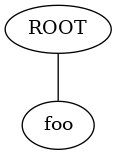

In [856]:
OG=nx.OrderedGraph()
OG.add_node('ROOT')
OG.add_node('foo:5fffffff')
OG.add_edge('ROOT', 'foo:5fffffff')
pdot = nx.drawing.nx_pydot.to_pydot(OG)
png_str = pdot.write_png('/tmp/graph.png')
display(Image(filename='/tmp/graph.png'))

In [858]:
mcts = FasterMCTS(model, env)

In [870]:
current_states = env.strings_to_state(['[BOS]What is 31+4453?[SP]'])
example_objects = [{'answer':'[BOS]What is 31+444?4484[EOS]', 'match_fn':env.match_no_SP_fn}]

In [849]:
mcts.search(current_states, example_objects)

tensor([-1.])

In [875]:
for i in tqdm.tqdm(range(100)):
    mcts.search(current_states, example_objects)

100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


In [829]:
mcts.cache['[BOS]What is 756+593?[SP]756+593>>>1349[NL]']

{'state': tensor([  1, 269, 268, 229,  31,  29,  30,  19,  29,  33,  27,  39,   6,  31,
          29,  30,  19,  29,  33,  27,   8,  25,  27,  28,  33,   5]),
 'N': tensor([21.]),
 'Qa': tensor([ 0.0000,  0.0000, -1.0000,  0.0000,  0.0000,  0.0000, -0.2890, -0.9192,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.4774, -0.0146,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.6597,
         -0.2736, -0.4749,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.2835,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
    

In [834]:
pi = mcts.getActionProb(env.strings_to_state(['[BOS]What is 756+593?[SP]756+593>>>1349[NL][ESP]']), temp=100)[0]
env.to_hash(pi.argsort(descending=True).reshape(-1,1)[:10])

['3', '4', '9', '1', '�', '�', '�', '�', '�', '�']

In [852]:
current_states.shape

torch.Size([1, 27])

In [850]:
node = mcts.cache['[BOS]What is 31+4453?[SP]']
N = node['N']
print(N)
Nas = node['Na']
print(Nas)
env.to_hash(Nas.argsort(descending=True).reshape(-1,1)[:10])

tensor([7.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

['3', '4', '9', '1', '�', '�', '�', '�', '�', '�']

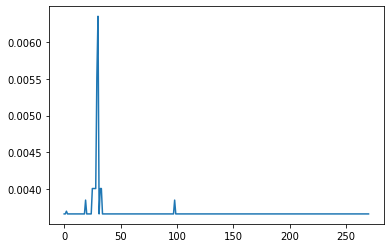

In [808]:
plt.plot(pi)

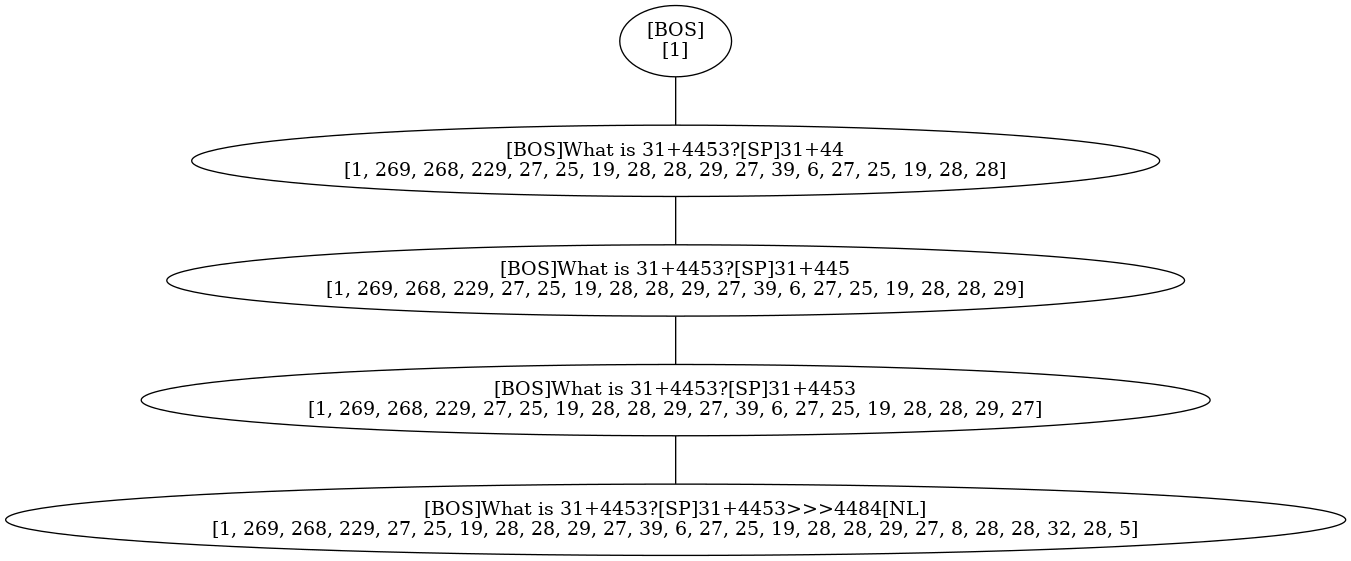

In [876]:
mcts.plot(from_state=env.strings_to_state(['What is 31+4453?[SP]31+44'])[0])

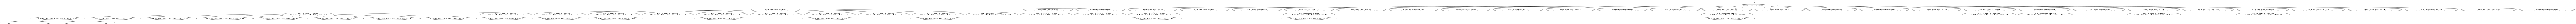

In [863]:
mcts.plot()

## Full arithmetic Few-shot learning
We will train the model to learn to copy sequences then give only 10 examples of arithmetic using supervised learning.
I then want to test how well the MCTS approaches new sequences.

In [877]:
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')
env = Scratch_Pad_Environment(tokenizer, device='cpu')

args = {'num_episodes':1000,
        'num_sims_per_turn':2,
        'policy_exploration_weight':0.5}

In [934]:
config = BertConfig()
config.num_attention_heads = 8
config.hidden_size = 256
config.num_hidden_layers = 12
config.intermediate_size = 1024
config.n_ctx = 512
config.n_positions = 512
config.is_decoder = True
config.temp = 1
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'
model = CausalBERT(config, bos_id=tokenizer.token_to_id('[BOS]'), 
                            pad_id=tokenizer.token_to_id('[PAD]'))

In [949]:
trainer = AlphaZero_Trainer(model, env)

### Supervised training to copy

In [936]:
example_objects = env.customPromptsAndAnswers(prompt_type='variable_span_copying', n=50000)
prompt_strings = [s['prompt'] for s in example_objects]
gold_strings = [s['gold'] for s in example_objects]
positive_samples = trainer.decomposeSupervisedEpisodes(gold_strings, prompt_strings=prompt_strings)

positive_samples = Class_Rebalance_Transform(field='target_values')(positive_samples)
train_dataset = Scratch_Pad_Policy_Dataset(positive_samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(16, shuffle=True)

# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=2)
model.train()
pl_trainer.fit(model, train_dataloader)

No correct seed found, seed set to 3593854453


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name        | Type      | Params
------------------------------------------
0 | transformer | BertModel | 10 M  
1 | lm_head     | Linear    | 69 K  
2 | value_head  | Linear    | 256   
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [937]:
torch.save(model.state_dict(), 'saved_models/ScratchPad/CBERT_copy_1k.ckpt')

### Testing copying abilities

In [1000]:
_ = model.eval()
current_states = env.strings_to_state(['[BOS]Copy "S9Hi":S9H'])
print(current_states)
example_objects = [{'answer':'[BOS]Copy "S9Hi":S9Hi', 'match_fn':env.match_no_SP_fn}]
p, v = model.predict(current_states)
env.to_hash(p.argsort(descending=True, dim=1).reshape(-1,1)[:10])

tensor([[  1,  43,  87,  88,  97, 229,  10,  59,  33,  48,  81,  10,  34,  59,
          33,  48]])


['i', '[EOS]', '9', 'y', 'v', 'J', 'A', 'u', 'h', 'P']

### Fine-tuning on 10 samples of arithmetic and some copying also
I think the amount I will use is 10 of arithmetic and 30 of copying

In [1136]:
model.load_state_dict(torch.load('saved_models/ScratchPad/CBERT_copy_1k.ckpt'))

<All keys matched successfully>

In [1137]:
copy_objects = env.customPromptsAndAnswers(prompt_type='variable_span_copying', n=30)
arithmetic_objects = env.customPromptsAndAnswers(prompt_type='simple_addition', n=10)
all_objects = copy_objects + arithmetic_objects

prompt_strings = [s['prompt'] for s in all_objects]
gold_strings = [s['gold'] for s in all_objects]
positive_samples = trainer.decomposeSupervisedEpisodes(gold_strings, prompt_strings=prompt_strings)

positive_samples = Class_Rebalance_Transform(field='target_values')(positive_samples)
train_dataset = Scratch_Pad_Policy_Dataset(positive_samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(16, shuffle=True)

# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=40)
model.train()
pl_trainer.fit(model, train_dataloader)

No correct seed found, seed set to 3694363523
No correct seed found, seed set to 552808822


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name        | Type      | Params
------------------------------------------
0 | transformer | BertModel | 10 M  
1 | lm_head     | Linear    | 69 K  
2 | value_head  | Linear    | 256   
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [1138]:
[s['gold'] for s in arithmetic_objects]

['[BOS]What is 4+0?[SP]4+0>>>4[NL][ESP]4[EOS]',
 '[BOS]What is 3+3?[SP]3+3>>>6[NL][ESP]6[EOS]',
 '[BOS]What is 1+3?[SP]1+3>>>4[NL][ESP]4[EOS]',
 '[BOS]What is 3+2?[SP]3+2>>>5[NL][ESP]5[EOS]',
 '[BOS]What is 1+0?[SP]1+0>>>1[NL][ESP]1[EOS]',
 '[BOS]What is 4+3?[SP]4+3>>>7[NL][ESP]7[EOS]',
 '[BOS]What is 2+0?[SP]2+0>>>2[NL][ESP]2[EOS]',
 '[BOS]What is 1+2?[SP]1+2>>>3[NL][ESP]3[EOS]',
 '[BOS]What is 0+3?[SP]0+3>>>3[NL][ESP]3[EOS]']

In [1218]:
_ = model.eval()
current_states = env.strings_to_state(['[BOS]What is 4+2?[SP]4+2'])
example_objects = [{'answer':'[BOS]What is 4+3?7[EOS]', 'match_fn':env.match_no_SP_fn}]
p, v = model.predict(current_states)
indices = torch.argsort(p, descending=True, dim=1)
print(f"State Value: {float(v):0.2f}")
for idx in indices.reshape(-1,1)[:10]:
    print(f"{env.to_hash(idx.unsqueeze(0))[0]} -> {float(100*p[0,idx]):0.1f}%")

State Value: 1.12
>>> -> 55.4%
4 -> 7.6%
+ -> 5.2%
[ESP] -> 5.0%
[EOS] -> 0.9%
e -> 0.8%
2 -> 0.7%
0 -> 0.7%
3 -> 0.6%
[SP] -> 0.6%


In [1193]:
mcts = FasterMCTS(model, env)

In [1176]:
mcts.cache['[BOS]What is 4+3?[SP]4+3>>>7[NL][SP]7']

{'state': tensor([  1, 269, 268, 229,  28,  19,  27,  39,   6,  28,  19,  27,   8,  31,
           5,   6,  31]),
 'N': tensor([2.]),
 'Qa': tensor([ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [1219]:
node = mcts.cache['[BOS]What is 4+2?[SP]4+2']
N = node['N']
print(N)
Nas = node['Na']
print(Nas)
env.to_hash(Nas.argsort(descending=True).reshape(-1,1)[:10])

tensor([62.])
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

['+', '4', '>>>', '�', '�', '�', '�', '�', '�', '�']

100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


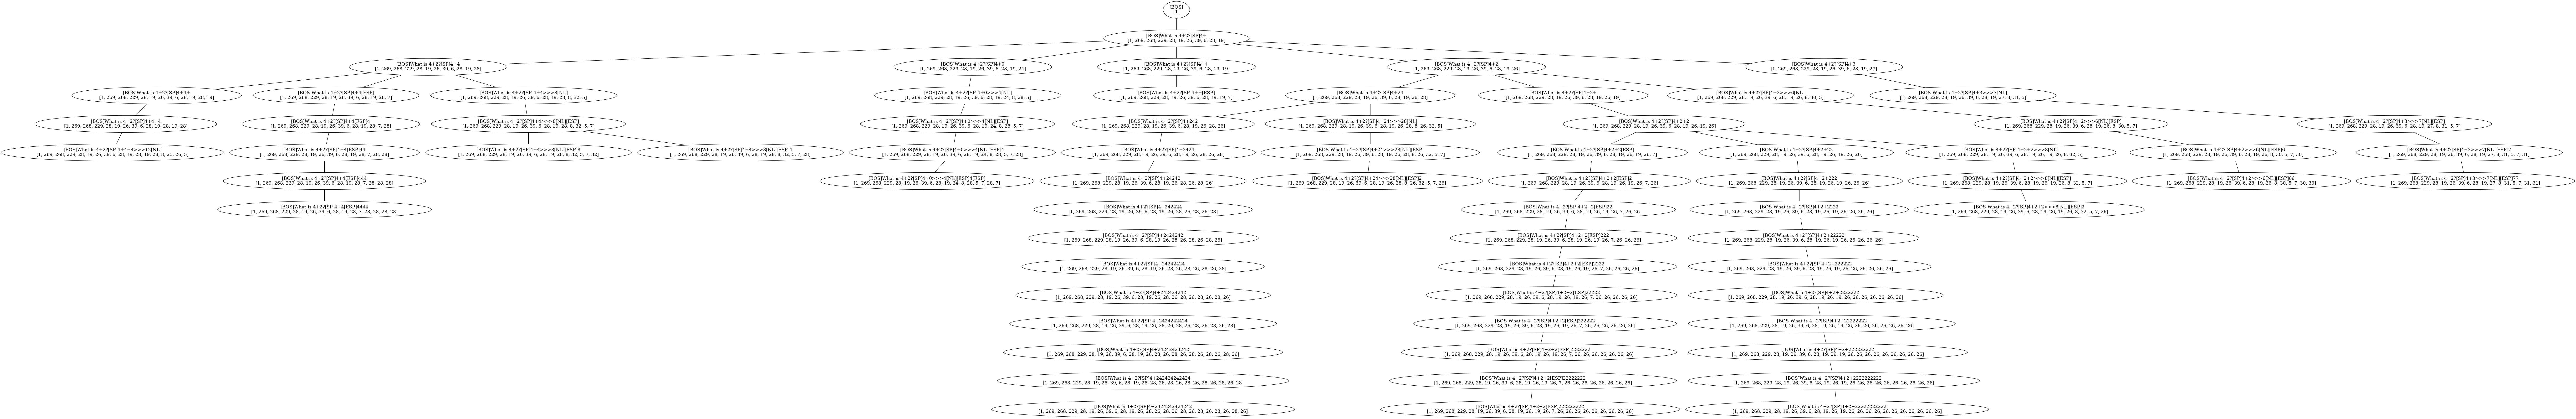

In [1212]:
current_states = env.strings_to_state(['[BOS]What is 4+2?[SP]4+'])
for i in tqdm.tqdm(range(30)):
    mcts.search(current_states, example_objects)
mcts.plot()

In [1263]:
prompt_strings = ['[BOS]What is 4+6?[SP]', 
                  '[BOS]What is 4+6?[SP]4', 
                  '[BOS]What is 4+6?[SP]4+', 
                  '[BOS]What is 4+6?[SP]4+6', 
                  '[BOS]What is 4+6?[SP]4+6>>>10[NL]', 
                  '[BOS]What is 4+6?[SP]4+6>>>10[NL][ESP]',
                  '[BOS]What is 4+6?[SP]4+6>>>10[NL][ESP]1',
                  '[BOS]What is 4+6?[SP]4+6>>>10[NL][ESP]10']
prompt_states = env.strings_to_state(prompt_strings)
target_objects = [{'answer':'[BOS]What is 4+6?10[EOS]', 'match_fn':env.match_no_SP_fn}]*8

explored_samples = trainer.execute_episodes(simulations=20, force_states=prompt_states, force_targets=target_objects, seed=10)

Sims for 8 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

For 100 episodes found 8 unique.


Sims for 7 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['+', '4', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['[SP]', '>>>', '+', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['4', '0', '3', '+', '>>>', '�', '�', '�', '�', '�']
Top_actions: ['[ESP]', '+', '4', '>>>', '[EOS]', '�', '�', '�', '�', '�']
Top_actions: ['x', '>>>', '[ESP]', '1', '0', 'L', '7', '[EOS]', '�', '�']
Top_actions: ['1', '0', '4', '3', '2', '6', '7', 't', 'c', 'z']
Top_actions: ['[ESP]', '[EOS]', '6', 'L', '0', '�', '�', '�', '�', '�']
Top_actions: ['[EOS]', '1', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['+', '[SP]', '4', '[ESP]', '�', 'b', '[ESP]', '[EOS]']
1 terminated, 7 left.


Sims for 6 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['+', '0', '4', '3', '>>>', '�', '�', '�', '�', '�']
Top_actions: ['4', '3', '>>>', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['+', '>>>', '[ESP]', '4', '�', '�', '�', '�', '�', '�']
Top_actions: ['6', '4', '>>>', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['[EOS]', '[ESP]', '1', '0', '6', 'N', 'e', '3', '�', '�']
Top_actions: ['[ESP]', '[EOS]', 'N', 't', '0', '1', '2', '�', '�', '�']
Top_actions: ['1', '0', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
chose: ['+', '4', '+', '6', '[EOS]', '�', '1']
1 terminated, 6 left.


Sims for 6 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '2', '3', '+', '>>>', '�', '�', '�', '�', '�']
Top_actions: ['+', '>>>', '[ESP]', '4', '0', '�', '�', '�', '�', '�']
Top_actions: ['4', '3', '[ESP]', '[EOS]', '>>>', '�', '�', '�', '�', '�']
Top_actions: ['t', '6', '[ESP]', '>>>', 'u', '[EOS]', '�', '�', '�', '�']
Top_actions: ['L', '[EOS]', '0', '1', '[ESP]', 'b', 't', '�', '�', '�']
Top_actions: ['6', '1', 't', '0', 'L', '[EOS]', '�', '�', '�', '�']
chose: ['0', '>>>', '4', 't', 'b', '6']
0 terminated, 6 left.


Sims for 6 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['[ESP]', '>>>', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '4', '>>>', '[ESP]', '[EOS]', '�', '�', '�', '�', '�']
Top_actions: ['>>>', '[ESP]', '4', '[EOS]', '�', '�', '�', '�', '�', '�']
Top_actions: ['6', 't', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['[ESP]', '7', '[EOS]', 't', '0', 'b', 'v', '�', '�', '�']
Top_actions: ['1', '[EOS]', '�', '�', '�', '�', '�', '�', '�', '�']
chose: ['[ESP]', 't', '>>>', '6', '�', '1']
0 terminated, 6 left.


Sims for 6 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '>>>', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '[ESP]', '>>>', '[EOS]', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', '[ESP]', '2', '[EOS]', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '6', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['b', '[EOS]', 'k', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', '6', 'x', 't', 'L', 'R', '0', 'u', 'h', 'O']
chose: ['0', '[ESP]', '1', 't', 'b', '|']
0 terminated, 6 left.


Sims for 6 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '>>>', '[ESP]', '[EOS]', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '7', '3', '4', '6', '[EOS]', '�', '�', '�', '�']
Top_actions: ['1', '2', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['6', 't', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['b', '7', 'k', 't', '1', 'x', '6', 'X', 'v', '0']
Top_actions: ['1', 'h', '6', '0', 'x', 'O', 'L', '[EOS]', '�', '�']
chose: ['0', 't', '1', '6', '1', '0']
0 terminated, 6 left.


Sims for 5 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '[ESP]', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '3', '[ESP]', '[EOS]', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', '2', 't', '[EOS]', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '6', '[ESP]', 'k', '[EOS]', '7', '�', '�', '�', '�']
Top_actions: ['b', '7', 'k', '0', '6', 't', 'f', 'A', 'T', '[EOS]']
Top_actions: ['1', 'R', 'L', 'O', 'u', 'c', 't', '6', '7', 'o']
chose: ['0', 't', '1', 't', '�', '1']
1 terminated, 5 left.


Sims for 4 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '[ESP]', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '3', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', '2', 't', '6', '[EOS]', '�', '�', '�', '�', '�']
Top_actions: ['6', 't', 'u', '[EOS]', '7', '�', '�', '�', '�', '�']
Top_actions: ['b', 'N', '6', '0', '1', '2', 't', 'L', 'x', '7']
chose: ['0', 't', '1', '6', '�']
1 terminated, 4 left.


Sims for 4 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '[ESP]', '�', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '7', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', '2', '6', 't', 'L', '[EOS]', 'u', '�', '�', '�']
Top_actions: ['t', '6', 'o', 'x', 'u', '3', '7', '[EOS]', 'k', 'R']
chose: ['0', 't', '1', 't']
0 terminated, 4 left.


Sims for 4 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '[ESP]', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '3', '7', '[EOS]', '�', '�', '�', '�', '�', '�']
Top_actions: ['1', '2', '6', 'x', 'u', 'q', 'L', '7', 't', 'R']
Top_actions: ['6', 'u', 'x', 't', 'Y', 'k', '7', '[EOS]', '�', '�']
chose: ['0', 't', 'R', '6']
0 terminated, 4 left.


Sims for 3 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '[ESP]', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', '7', 'o', '3', '[EOS]', '�', '�', '�', '�', '�']
Top_actions: ['1', 'h', 'W', 't', 'U', '7', '5', 'x', '3', '2']
Top_actions: ['t', '6', 'x', 'u', 'c', 'j', '7', '3', 'R', 'o']
chose: ['0', 't', '6', '�']
1 terminated, 3 left.


Sims for 3 episodes:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s]

Top_actions: ['0', '[ESP]', '[EOS]', '�', '�', '�', '�', '�', '�', '�']
Top_actions: ['t', 'o', 'R', '7', '3', '6', 'L', '[EOS]', '�', '�']
Top_actions: ['6', 'i', 'u', 'x', 't', '3', 'k', '[EOS]', 'W', 'Y']
chose: ['0', 't', 'K']
0 terminated, 3 left.


Sims for 2 episodes:   0%|          | 0/20 [00:00<?, ?it/s]

Top_actions: ['0', '[ESP]', '7', '8', '[EOS]', 'L', '�', '�', '�', '�']
Top_actions: ['t', '7', 'c', 'R', '2', '3', 'o', '6', 'L', 'k']
Top_actions: ['6', 'Y', 'F', 'u', 't', 'b', 'R', '7', 'o', 'W']
chose: ['0', 't', '�']
1 terminated, 2 left.


Sims for 2 episodes:  10%|█         | 2/20 [00:00<00:01, 11.15it/s]

Top_actions: ['0', 'x', '7', '8', 'd', 'L', '3', '[ESP]', '>>>', '6']
Top_actions: ['t', 'R', 'L', '2', 'c', '3', '6', 'o', '7', 'x']
chose: ['0', 't']
0 terminated, 2 left.


Sims for 1 episodes:  15%|█▌        | 3/20 [00:00<00:00, 24.39it/s]

Top_actions: ['0', 'I', '>>>', '[ESP]', 'K', 's', '6', 'x', '7', 't']
Top_actions: ['t', '6', 'F', '9', 'w', 'L', 'u', '7', 'I', 'x']
chose: ['0', 't']
1 terminated, 1 left.


Sims for 1 episodes: 100%|██████████| 20/20 [00:00<00:00, 21.46it/s]

Top_actions: ['0', 'N', '6', '7', '8', 'G', 'H', 'I', 'K', 'L']
chose: ['�']
1 terminated, 0 left.
Performed 8 episodes in 91.17s.


In [1269]:
env.to_hash(explored_samples[4]['input_ids'][explored_samples[4]['not_auto_gen_mask']].unsqueeze(0))

['+4+4[NL]11111R']

In [1268]:
explored_samples[4]

{'state_string': '[BOS]What is 4+6?[SP]4+4+4>>>12[NL]11111R',
 'input_ids': tensor([  1, 269, 268, 229,  28,  19,  30,  39,   6,  28,  19,  28,  19,  28,
           8,  25,  26,   5,  25,  25,  25,  25,  25,  58]),
 'target_policies': tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [2.2574e-06, 2.2574e-06, 6.1361e-06,  ..., 2.2574e-06, 2.2574e-06,
          2.2574e-06],
         [1.2634e-03, 1.2634e-03, 3.4342e-03,  ..., 1.2634e-03, 1.2634e-03,
          1.2634e-03],
         [2.2426e-03, 2.2426e-03, 6.0961e-03,  ..., 2.2426e-03, 2.2426e-03,
          2.2426e-03]]),
 'target_values': tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),

In [1264]:
explored_samples

[{'state_string': '[BOS]What is 4+6?[SP]4+6>>>10[NL][ESP]10',
  'input_ids': tensor([  1, 269, 268, 229,  28,  19,  30,  39,   6,  28,  19,  30,   8,  25,
           24,   5,   7,  25,  24]),
  'target_policies': tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [4.1399e-08, 4.1399e-08, 9.9999e-01,  ..., 4.1399e-08, 4.1399e-08,
           4.1399e-08]]),
  'target_values': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1.]),
  'not_auto_gen_mask': tensor([False, False, False,

In [989]:
all_samples = positive_samples + explored_samples

all_samples = Class_Rebalance_Transform(field='target_values')(all_samples)
train_dataset = Scratch_Pad_Policy_Dataset(all_samples, slow_pipe=[], real_time_pipe=[])
train_dataloader = train_dataset.to_dataloader(16, shuffle=True)

# wandb_logger = WandbLogger(name='GPT2_variable_span_copying_with_solution_1k_supervised',project='ScratchPad')
pl_trainer = Trainer(gpus=1, gradient_clip_val=0.5, amp_level='O1', max_epochs=20)
model.train()
pl_trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name        | Type      | Params
------------------------------------------
0 | transformer | BertModel | 10 M  
1 | lm_head     | Linear    | 69 K  
2 | value_head  | Linear    | 256   


1